# 축구 데이터분석 7주차
- 시각화를 통해 트래킹 데이터 살펴보기
- 활동량 분석
- 보로노이 다이어그램
- Pitch Control

In [ ]:
!git clone https://github.com/narame7/UOS-FootballDataAnalytics-Tutorial.git

In [ ]:
%cd 'UOS-FootballDataAnalytics-Tutorial/week7'

## 데이터 불러오기

xml 형태의 트래킹 데이터 다운로드 (코랩의 메모리 상 아마 안될 확률이 높습니다)

In [ ]:
!tar -xJvf data.tar.xz -C /content/UOS-FootballDataAnalytics-Tutorial/week7/


data/DFL-MAT-J03WMX/
data/DFL-MAT-J03WMX/DFL_03_02_events_raw_DFL-COM-000001_DFL-MAT-J03WMX.xml
data/DFL-MAT-J03WMX/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml
data/DFL-MAT-J03WMX/DFL_02_01_matchinformation_DFL-COM-000001_DFL-MAT-J03WMX.xml


필요한 라이브러리 설치

In [ ]:
!pip install floodlight mplsoccer shapely==2.1.2 pandera av imageio-ffmpeg numba==0.62.1

In [ ]:
import os
import sys
import json
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from mplsoccer import Pitch
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, box
from matplotlib.animation import FuncAnimation
from dfl import load_all_data

In [9]:
path = os.path.join(os.getcwd(), "data")
dfl_events, dfl_traces, dfl_teams = load_all_data(path)  

Found matches: ['DFL-MAT-J03WMX']
--- Processing DFL-MAT-J03WMX ---
Processing match: DFL-MAT-J03WMX
Reading XML data...
Assembling initial wide DataFrame...
Reshaping to long format and calculating kinematics...


Processing agents: 100%|██████████| 41/41 [00:14<00:00,  2.89it/s]


Finished processing DFL-MAT-J03WMX. Final shape: (3357241, 20)


/home/2025FDA/week7/utils_data.py:165: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  botid_series = players_df_with_ball_pos.groupby(Group.BY_FRAME, group_keys=True).apply(
/home/2025FDA/week7/utils_data.py:186: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bopid_series = players_df_with_ball_pos.groupby(Group.BY_FRAME, group_keys=True).apply(


Restoring wide format...
extracting coordinates from tracking data...

--- All matches processed. Returning aggregated DataFrames. ---


### 전처리가 안 될 경우

In [ ]:
!tar -xJvf "dfl_data.tar.xz"

In [ ]:
dfl_traces = pd.read_csv('dfl_traces.csv', index_col=0)
dfl_teams = pd.read_csv('dfl_teams.csv', index_col=0)
dfl_events = pd.read_csv('dfl_events.csv', index_col=0)

In [19]:
dfl_traces.head(5)
# time이 0.04초 간격 -> 25HZ

frame_id  time  period_id ball_state ball_owning_team_id  B00_x  B00_y  \
0     10000  0.00          1      alive      DFL-CLU-00000G  52.68  33.83   
1     10001  0.04          1      alive      DFL-CLU-00000G  52.10  33.81   
2     10002  0.08          1      alive      DFL-CLU-00000G  51.53  33.79   
3     10003  0.12          1      alive      DFL-CLU-00000G  50.96  33.76   
4     10004  0.16          1      alive      DFL-CLU-00000G  50.38  33.74   

   A00_speed    A00_vx    A00_vy  ...  H18_speed    H18_vx    H18_vy  H18_x  \
0   0.518165  0.517857 -0.017857  ...   1.439689 -0.714286  1.250000  63.87   
1   0.571429  0.571429  0.000000  ...   1.439689 -0.714286  1.250000  63.84   
2   0.625255  0.625000  0.017857  ...   1.439689 -0.714286  1.250000  63.81   
3   0.679511  0.678571  0.035714  ...   1.439689 -0.714286  1.250000  63.79   
4   0.715178  0.714286  0.035714  ...   1.470804 -0.714286  1.285714  63.76   

   H18_y  H19_speed  H19_vx  H19_vy  H19_x  H19_y  
0  39.18        NaN     NaN     NaN    NaN    NaN  
1  39.23        NaN     NaN     NaN    NaN    NaN  
2  39.28        NaN     NaN     NaN    NaN    NaN  
3  39.33        NaN     NaN     NaN    NaN    NaN  
4  39.38        NaN     NaN     NaN    NaN    NaN  

[5 rows x 207 columns]

In [7]:
dfl_events.head(5)

Unnamed: 0                eID  gameclock             tID             pID  \
0           0  KickOff_Play_Pass      0.000  DFL-CLU-00000G  DFL-OBJ-0027G6   
1           1          Play_Pass      2.829  DFL-CLU-00000G  DFL-OBJ-0027KL   
2           2  ThrowIn_Play_Pass     21.551  DFL-CLU-000008  DFL-OBJ-0002BO   
3           3       TacklingGame     22.268  DFL-CLU-000008  DFL-OBJ-J01BGM   
4           4    OtherBallAction     22.733  DFL-CLU-00000G  DFL-OBJ-0027KL   

   outcome                         timestamp  minute  second  \
0      NaN  2023-05-27 15:30:12.230000+02:00     0.0     0.0   
1      NaN  2023-05-27 15:30:15.059000+02:00     0.0     2.0   
2      NaN  2023-05-27 15:30:33.781000+02:00     0.0    21.0   
3      1.0  2023-05-27 15:30:34.498000+02:00     0.0    22.0   
4      NaN  2023-05-27 15:30:34.963000+02:00     0.0    22.0   

                                           qualifier  period_id  team  \
0  {'TeamLeft': 'DFL-CLU-00000G', 'TeamRight': 'D...          1  Away   
1  {'SemiField': 'false', 'Player': 'DFL-OBJ-0027...          1  Away   
2  {'Team': 'DFL-CLU-000008', 'Side': 'right', 'D...          1  Home   
3  {'WinnerTeam': 'DFL-CLU-00000G', 'Winner': 'DF...          1  Home   
4  {'Player': 'DFL-OBJ-0027KL', 'Team': 'DFL-CLU-...          1  Away   

         match_id   start_x   start_y  
0  DFL-MAT-J03WMX  53.28000  33.46000  
1  DFL-MAT-J03WMX  38.57175  33.30550  
2  DFL-MAT-J03WMX  68.63575  63.81800  
3  DFL-MAT-J03WMX  53.22700  59.25000  
4  DFL-MAT-J03WMX  48.33075  53.38125

독일어 축구 포지션 정리

In [12]:
PLAYER_ROLE_ABBR = {'RV':'RB','LV':'LB','IVR':'CB','IVZ':'CB','IVL':'CB','DRM':'CDM',
                    'DMR':'CDM','DML':'CDM','DLM':'CDM','DMZ':'CDM','HL':'CM','HR':'CM',
                    'MZ':'CM','LM':'LM','RM':'RM','ORM':'CAM','OLM':'CAM','ZO':'CAM',
                    'OHL':'CAM','OHR':'CAM','STR':'ST','STZ':'ST','STL':'ST','RA':'RW',
                    'LA':'LW','TW':'GK'}

In [8]:
dfl_teams['tracking_id'] = dfl_teams['team'].str[0] + dfl_teams['xID'].astype(str).str.zfill(2)

## 트레킹 데이터 살펴보기

In [9]:
dfl_teams[dfl_teams['tracking_id']=='A10']

Unnamed: 0      player position  team  jID             pID  \
30          30  Leroy Sané      ORM  Away   10  DFL-OBJ-0002AU   

               tID  xID        match_id tracking_id  
30  DFL-CLU-00000G   10  DFL-MAT-J03WMX         A10

(1) 특정 선수의 움직임 빈도 살펴보기

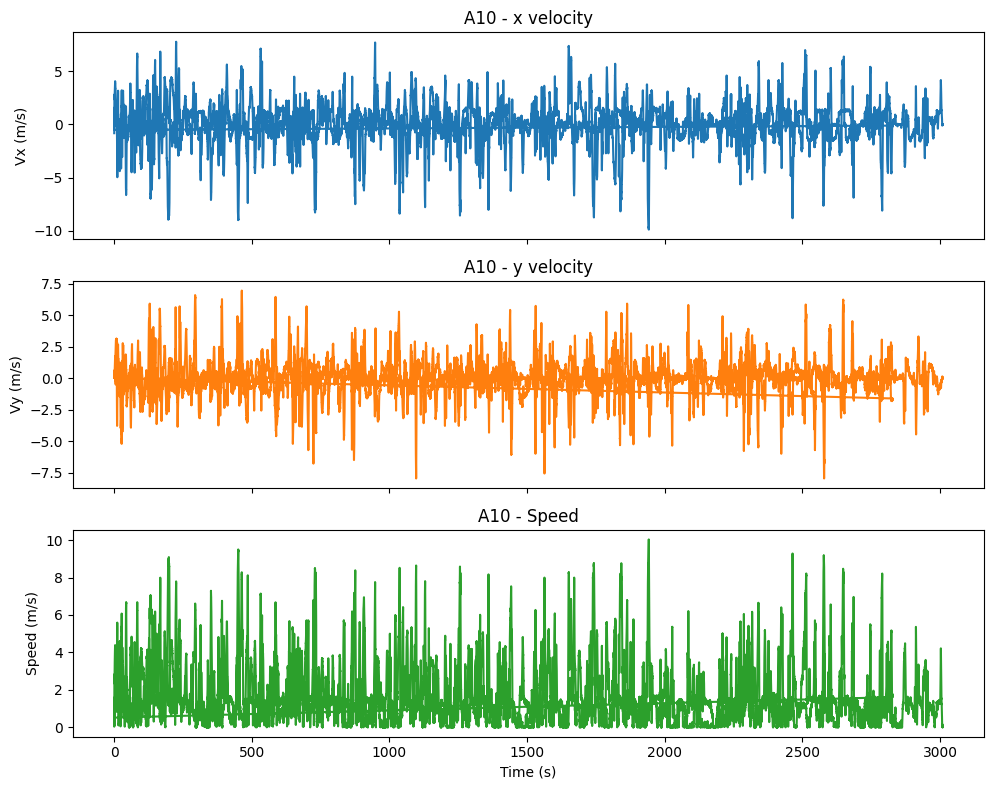

In [14]:
# 시간 간격(dt), 속도(vx, vy, speed)
player = 'A10'
dt = dfl_traces['time'].diff()
vx = dfl_traces[f'{player}_vx']
vy = dfl_traces[f'{player}_vy']
speed = dfl_traces[f'{player}_speed']

# 3개의 개별 플롯 생성
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)


axes[0].plot(dfl_traces['time'], vx, color='tab:blue')
axes[0].set_ylabel('Vx (m/s)')
axes[0].set_title(f'{player} - x velocity')


axes[1].plot(dfl_traces['time'], vy, color='tab:orange')
axes[1].set_ylabel('Vy (m/s)')
axes[1].set_title(f'{player} - y velocity')


axes[2].plot(dfl_traces['time'], speed, color='tab:green')
axes[2].set_ylabel('Speed (m/s)')
axes[2].set_xlabel('Time (s)')
axes[2].set_title(f'{player} - Speed')

plt.tight_layout()
plt.show()

(2) 경기 장면 시각화

In [15]:
'''
기본 Pitch Design
'''
custom_pitch = Pitch(pitch_type='custom', pitch_color='grass', line_color='white', stripe=True, pitch_width=68, pitch_length=105, axis=True, label=True)

In [16]:
def plot_frame(pitch, tracking_df, frame, ax=None):

	is_single_plot = False
	if ax is None:
		is_single_plot = True
		fig, ax = pitch.draw(figsize=(12, 8))

	data = tracking_df.loc[frame]

	team_color_map = {'H': 'blue', 'A': 'red'}
	team_name_map = {'H': 'Home', 'A': 'Away'}

	# 팀별 시각화
	for team in ['H', 'A']:
		color = team_color_map[team]
		x_cols = [c for c in data.keys() if c.startswith(team) and c.endswith('_x')]
		y_cols = [c for c in data.keys() if c.startswith(team) and c.endswith('_y')]
		vx_cols = [c for c in data.keys() if c.startswith(team) and c.endswith('_vx')]
		vy_cols = [c for c in data.keys() if c.startswith(team) and c.endswith('_vy')]

		# 선수 위치
		ax.scatter(data[x_cols], data[y_cols], s=330, c=color, alpha=0.7, label=team_name_map[team])

		# 선수 번호
		for x, y in zip(x_cols, y_cols):
			if not (np.isnan(data[x]) or np.isnan(data[y])):
				num = ''.join(ch for ch in x if ch.isdigit())
				ax.text(data[x], data[y], num, fontsize=8, color='w', fontweight='bold',
						ha='center', va='center')

		# 속도 벡터
		ax.quiver(
			data[x_cols].astype(float), data[y_cols].astype(float),
			data[vx_cols].astype(float), data[vy_cols].astype(float),
			color=color, scale=8, scale_units='inches', width=0.002, alpha=0.8
		)

	# 공 표시
	ax.scatter(data['B00_x'], data['B00_y'], s=60, color='w', edgecolors='k', zorder=5)

	# 시간 박스
	time_in_seconds = data['time']
	time_text = f"{int(time_in_seconds // 60):02d}:{time_in_seconds % 60:05.2f}"
	box_props = dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.6, edgecolor='white')
	ax.text(0.02, 0.98, f"{time_text}", transform=ax.transAxes,
			ha='left', va='top', color='white', fontsize=12,
			fontweight='bold', bbox=box_props)

	# 범례 설정
	legend_properties = {
		'loc': 'upper right',
		'fontsize': 10,
		'facecolor': 'black',
		'edgecolor': 'white',
		'labelcolor': 'white',
		'shadow': True,
		'framealpha': 0.6
	}
	ax.legend(**legend_properties)

	plt.show()


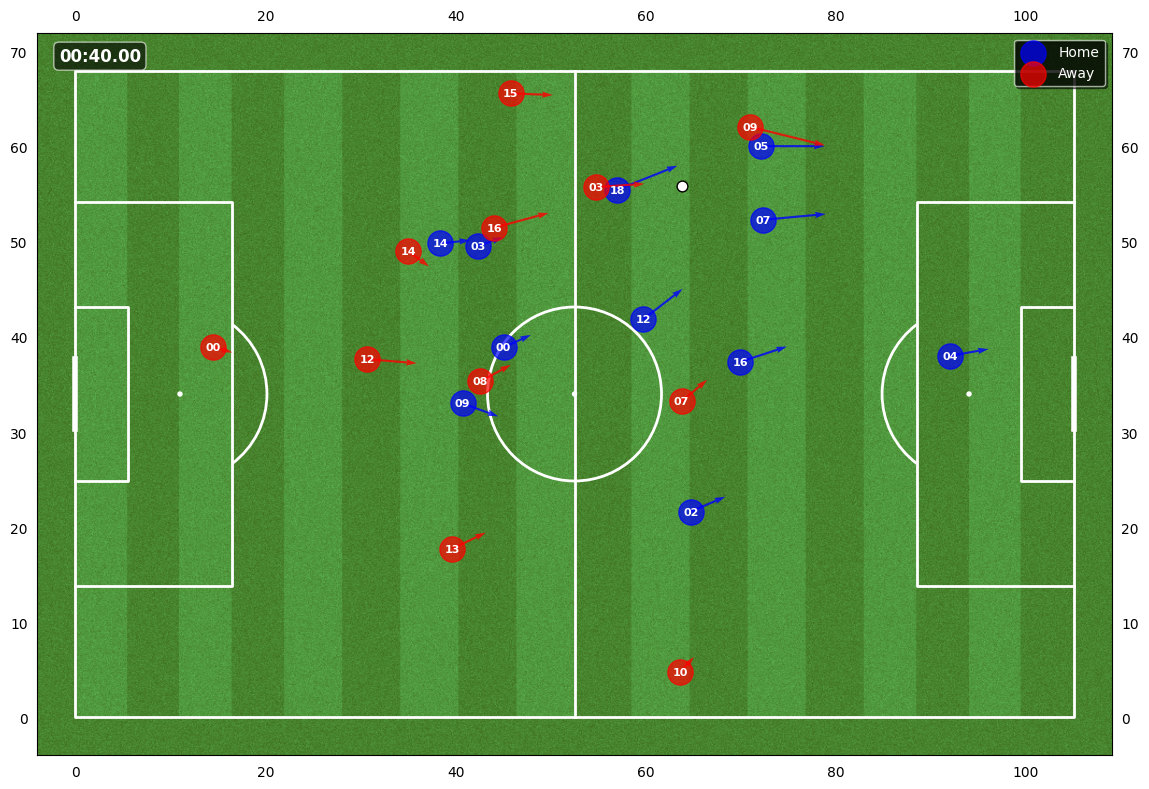

In [17]:
plot_frame(custom_pitch, dfl_traces, frame=1000)

(3) 애니메이션 만들기


Saving animation... This may take a moment.


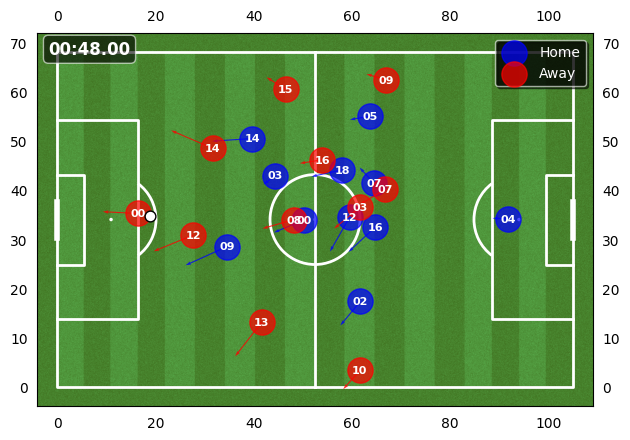

Animation saved as soccer_tracking_animation.mp4


In [19]:

fig, ax = custom_pitch.draw()

total_frames=25 #1장에 0.5초 정도 소요..?

def update(frame):
	# 이전 프레임의 선수, 공, 텍스트 등을 모두 지움
	ax.clear()
	# 경기장을 다시 그림 (clear()로 지워졌기 때문)
	custom_pitch.draw(ax)
	# 현재 프레임의 데이터를 그림
	plot_frame(custom_pitch, dfl_traces, frame, ax)
	print(f"Rendering frame: {frame+1}/{total_frames}", end="\r")
start_frame = 1200
end_frame = 1250

# interval: 프레임 간 지연 시간 (ms), 40ms = 25fps
ani = FuncAnimation(fig=fig, func=update, frames=range(start_frame, end_frame), interval=1)

# (5) 또는 파일로 저장하기
print("\nSaving animation... This may take a moment.")
ani.save('soccer_tracking_animation.mp4', writer='ffmpeg', fps=25)
print("Animation saved as soccer_tracking_animation.mp4")

## 활동량 분석

(1) 뛴 거리

In [20]:
player_dict = dict(zip(dfl_teams['tracking_id'], dfl_teams['player']))
player_dict['A10']
# 이름<->tracking_id 딕셔너리 만들기

'Leroy Sané'

In [21]:
def calc_run_dist(tracking_id: str):
	x = dfl_traces[f'{tracking_id}_x']
	y = dfl_traces[f'{tracking_id}_y']

	dx = x.diff().fillna(0)
	dy = y.diff().fillna(0)
	dist_per_frame = np.sqrt(dx**2 + dy**2)

	# 총 이동 거리 (km 단위)
	total_distance_m = dist_per_frame.sum()
	return total_distance_m

calc_run_dist('A10')

np.float64(9811.896852680784)

(2) 출전 시간

In [22]:
def calc_played_minutes(tracking_id: str):
	x = dfl_traces[f'{tracking_id}_x']
	y = dfl_traces[f'{tracking_id}_y']

	valid_mask = ~(x.isna() | y.isna())
	active_frames = valid_mask.sum()

	play_time_seconds = active_frames / 25
	play_time_minutes = play_time_seconds / 60

	return play_time_minutes

calc_played_minutes('A10')

np.float64(97.31133333333334)

(3) 1분당 뛴 거리

In [23]:
def calc_distance_per_minute(tracking_id: str):
	total_distance_m = calc_run_dist(tracking_id)
	play_time_min = calc_played_minutes(tracking_id)

	if play_time_min == 0:
		print("출전 시간이 0분입니다.")
		return None

	distance_per_min = total_distance_m / play_time_min
	return distance_per_min
calc_distance_per_minute('A10')

np.float64(100.82994977646437)

(4) 전체 선수들에 대해 정리

In [24]:
player_summary = []

for tracking_id, player_name in player_dict.items():
	total_distance_m = calc_run_dist(tracking_id)
	play_time_min = calc_played_minutes(tracking_id)
	if play_time_min == 0 or play_time_min is None:
		continue
	
	distance_per_min = total_distance_m / play_time_min

	# 결과 저장
	player_summary.append({
		"player": player_name,
		"tracking_id": tracking_id,
		"total_distance_km": total_distance_m / 1000,
		"play_time_min": play_time_min,
		"m_per_min": distance_per_min
	})
summary_df = pd.DataFrame(player_summary)
summary_df = summary_df.sort_values("m_per_min", ascending=False).reset_index(drop=True)

summary_df["total_distance_km"] = summary_df["total_distance_km"].round(2)
summary_df["play_time_min"] = summary_df["play_time_min"].round(1)
summary_df["m_per_min"] = summary_df["m_per_min"].round(2)

summary_df.head(20)


player tracking_id  total_distance_km  play_time_min  m_per_min
0           E. Martel         H18              12.78           97.3     131.38
1      Joshua Kimmich         A08              12.75           97.3     131.01
2            F. Kainz         H00               8.16           63.5     128.46
3       Ellyes Skhiri         H12              12.40           97.3     127.46
4           T. Müller         A03               8.12           63.7     127.36
5         D. Ljubicic         H14              10.63           83.5     127.25
6         T. Lemperle         H10               1.70           13.7     123.97
7    Ryan Gravenberch         A16               8.92           72.3     123.40
8          J. Musiala         A18               1.37           11.1     122.96
9        Serge Gnabry         A07              11.74           97.3     120.69
10     Kingsley Coman         A09               8.61           72.3     119.13
11     D. Huseinbašić         H17               4.01           33.7     118.77
12         B. Schmitz         H05               7.51           63.6     118.16
13           L. Maina         H09               9.68           83.6     115.89
14           D. Selke         H03               7.23           63.5     113.83
15      Leon Goretzka         A05               1.58           13.9     113.46
16        N. Mazraoui         A15               9.70           86.2     112.48
17  Kristian Pedersen         H08               1.54           13.8     111.78
18    Dayot Upamecano         A12              10.78           97.3     110.79
19      Jan Thielmann         H11               3.72           33.8     109.99

(5) 속도 구간 별 달리기 통계

In [26]:
speed_records = []

for tracking_id, player_name in player_dict.items():
	vx = dfl_traces[f'{tracking_id}_vx']
	vy = dfl_traces[f'{tracking_id}_vy']
	speed = np.sqrt(vx**2 + vy**2)  # m/s
	
	# m/s → km/h 변환
	speed_kmh = speed * 3.6
	
	# 프레임 간 이동 거리 (m)
	dx = dfl_traces[f'{tracking_id}_x'].diff().fillna(0)
	dy = dfl_traces[f'{tracking_id}_y'].diff().fillna(0)
	dist_per_frame = np.sqrt(dx**2 + dy**2)
	
	df = pd.DataFrame({
		"player": player_name,
		"tracking_id": tracking_id,
		"speed_kmh": speed_kmh,
		"distance": dist_per_frame
	})
	speed_records.append(df)

traces = pd.concat(speed_records, ignore_index=True)

# 속도 구간(bin) 설정
speed_bins = [0, 7, 15, 20, 25, 50]  # km/h 기준

speed_labels = ["걷기 (0-7)", "조깅 (7-15)", "러닝 (15-20)", "고속 질주 (20-25)", "스프린트 (25+)"]

traces["speed_zone"] = pd.cut(
	traces["speed_kmh"],
	bins=speed_bins,
	labels=speed_labels,
	right=False
)

# 속도 구간별 총 이동거리 계산 (pivot table)
distances_by_speed = traces.pivot_table(
	values="distance",
	index="player",
	columns="speed_zone",
	aggfunc="sum",
	fill_value=0
)

# km 단위로 변환 및 보기 좋게 정리
distances_by_speed = distances_by_speed / 1000  # meter → km
distances_by_speed = distances_by_speed.round(2)
distances_by_speed["Total_km"] = distances_by_speed.sum(axis=1).round(2)

# 정렬 (총거리 기준)
distances_by_speed = distances_by_speed.sort_values("Total_km", ascending=False)
distances_by_speed.head(10)


/tmp/ipykernel_803695/2168092075.py:39: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  distances_by_speed = traces.pivot_table(


speed_zone       걷기 (0-7)  조깅 (7-15)  러닝 (15-20)  고속 질주 (20-25)  스프린트 (25+)  \
player                                                                        
E. Martel            3.34       6.27        2.24           0.76        0.16   
Joshua Kimmich       3.44       6.34        2.36           0.49        0.12   
Ellyes Skhiri        3.86       6.10        1.78           0.55        0.11   
Serge Gnabry         3.93       4.91        1.84           0.90        0.16   
Dayot Upamecano      3.85       5.17        1.14           0.42        0.20   
D. Ljubicic          3.29       4.27        1.68           1.00        0.39   
M. de Ligt           3.58       5.32        1.26           0.33        0.06   
Benjamin Pavard      4.12       4.50        1.29           0.40        0.10   
Timo Hübers          3.79       4.96        1.08           0.36        0.11   
Jonas Hector         3.52       4.54        1.45           0.63        0.11   

speed_zone       Total_km  
player                     
E. Martel           12.77  
Joshua Kimmich      12.75  
Ellyes Skhiri       12.40  
Serge Gnabry        11.74  
Dayot Upamecano     10.78  
D. Ljubicic         10.63  
M. de Ligt          10.55  
Benjamin Pavard     10.41  
Timo Hübers         10.30  
Jonas Hector        10.25

### 활동량 시각화

/tmp/ipykernel_803695/484103649.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


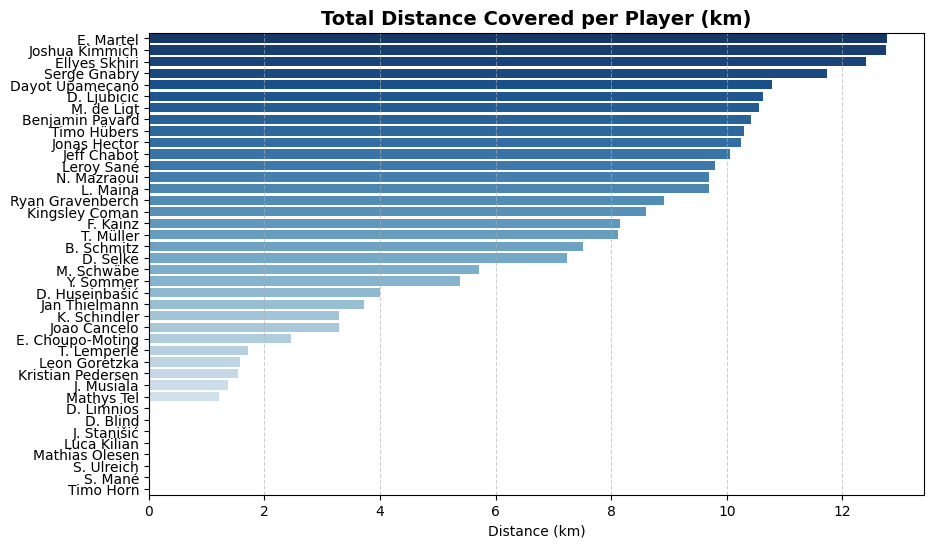

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
	data=distances_by_speed.sort_values("Total_km", ascending=False),
	x="Total_km", y="player", palette="Blues_r"
)
plt.title("Total Distance Covered per Player (km)", fontsize=14, weight="bold")
plt.xlabel("Distance (km)")
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


/tmp/ipykernel_803695/4091423043.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


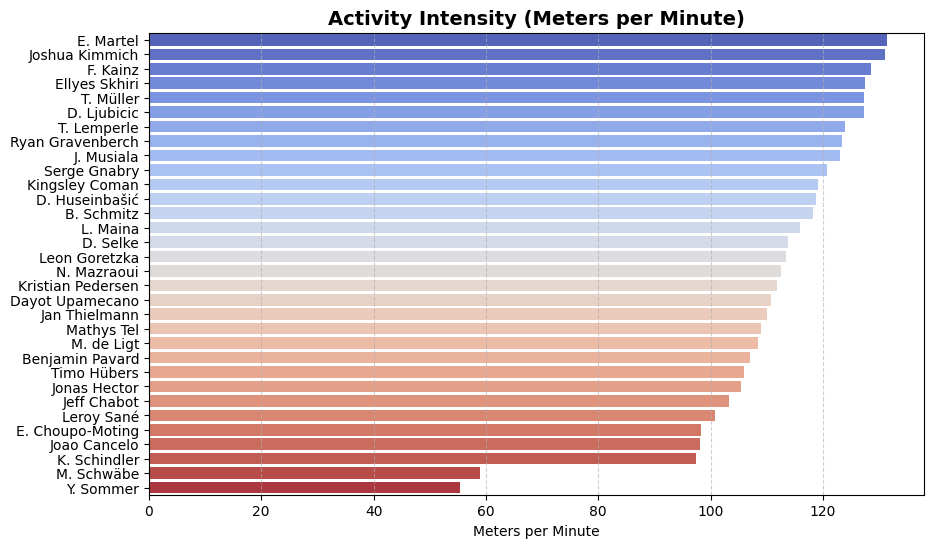

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(
	data=summary_df.sort_values("m_per_min", ascending=False),
	x="m_per_min", y="player", palette="coolwarm"
)
plt.title("Activity Intensity (Meters per Minute)", fontsize=14, weight="bold")
plt.xlabel("Meters per Minute")
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


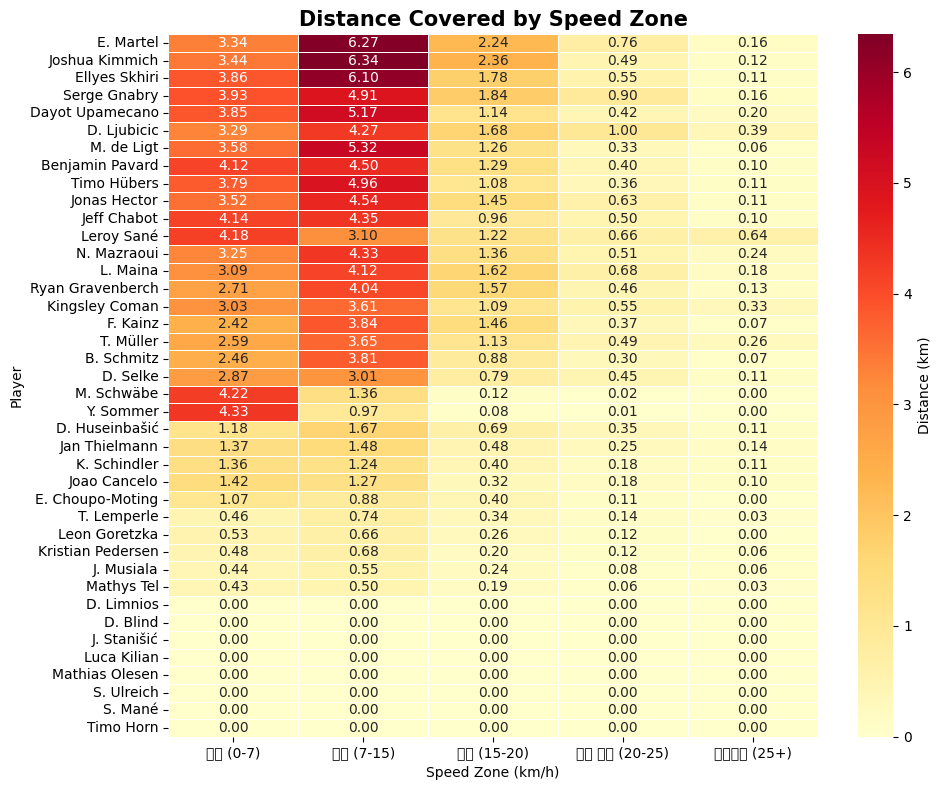

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(
	distances_by_speed.iloc[:, :-1],  # Total_km 제외
	cmap="YlOrRd", annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Distance (km)'}
)
plt.title("Distance Covered by Speed Zone", fontsize=15, weight="bold")
plt.xlabel("Speed Zone (km/h)")
plt.ylabel("Player")
plt.tight_layout()
plt.show()


In [31]:
def analyze_player_distance(dfl_traces, player_prefix, fps=25):
	'''
	특정 선수의 시간별, 구간별 스프린트 통계를 분석하는 함수
	'''
	vx_col = f"{player_prefix}_vx"
	vy_col = f"{player_prefix}_vy"
	if vx_col not in dfl_traces.columns or 'period_id' not in dfl_traces.columns:
		missing = 'period_id' if 'period_id' not in dfl_traces.columns else f"'{player_prefix}'"
		print(f"오류: 필수 컬럼({missing})을 찾을 수 없습니다.")
		return None

	df = dfl_traces.copy()


	speed_ms = np.sqrt(df[vx_col]**2 + df[vy_col]**2)
	speed_kmh = speed_ms * 3.6

	df['distance_km'] = speed_ms / fps / 1000  # (m/s) / (frame/s) = m/frame -> km/frame


	df['match_minute'] = np.where(
		df['period_id'] == 1,         
		df['time'] / 60,               
		45 + (df['time'] / 60)        
	)

	#  15분 단위 시간 구간 생성
	time_bins = [0, 15, 30, 45, 60, 75, 90]
	time_labels = ["0-15분", "15-30분", "30-45분", "45-60분", "60-75분", "75-90분"]
	df['time_cat'] = pd.cut(df['match_minute'], bins=time_bins, labels=time_labels, right=False)

	# 속도 구간 생성 (km/h 기준)
	speed_bins_kmh = [0, 7, 15, 20, 25, 100]
	speed_labels = ["걷기 (0-7)", "조깅 (7-15)", "러닝 (15-20)", "고속 질주 (20-25)", "스프린트 (25+)"]
	df['speed_zone'] = pd.cut(speed_kmh, bins=speed_bins_kmh, labels=speed_labels, right=False)

	player_stats = (
		df.groupby(['time_cat', 'speed_zone'], observed=False)['distance_km']
		.sum()
		.unstack(fill_value=0)
		.round(2)
	)
	
	# 총 이동 거리 합계 컬럼 추가
	player_stats['총 이동 거리 (km)'] = player_stats.sum(axis=1)

	return player_stats

In [32]:
player_running_by_time_stats = analyze_player_distance(dfl_traces, 'A10')
player_running_by_time_stats

speed_zone  걷기 (0-7)  조깅 (7-15)  러닝 (15-20)  고속 질주 (20-25)  스프린트 (25+)  \
time_cat                                                                 
0-15분           0.64       0.69        0.25           0.13        0.11   
15-30분          0.65       0.48        0.22           0.06        0.07   
30-45분          0.68       0.44        0.18           0.12        0.10   
45-60분          0.74       0.59        0.23           0.16        0.11   
60-75분          0.55       0.45        0.17           0.13        0.12   
75-90분          0.62       0.30        0.13           0.06        0.10   

speed_zone  총 이동 거리 (km)  
time_cat                  
0-15분               1.82  
15-30분              1.48  
30-45분              1.52  
45-60분              1.83  
60-75분              1.42  
75-90분              1.21

In [33]:
def plot_player_distance_chart(player_stats_df, player_prefix="Player"):

	plot_data = player_stats_df.drop(columns=['총 이동 거리 (m)'], errors='ignore')

	# 속도 구간 라벨 정의 (차트에 표시될 순서대로)
	# analyze_player_distance 함수와 일관되게 유지
	speed_labels_ordered = [
		"걷기 (0-7)", 
		"조깅 (7-15)", 
		"러닝 (15-20)", 
		"고속 질주 (20-25)", 
		"스프린트 (25+)"
	]
	
	# 데이터에 존재하는 컬럼만 필터링하고 순서 재정렬
	existing_speed_labels = [label for label in speed_labels_ordered if label in plot_data.columns]
	plot_data = plot_data[existing_speed_labels]

	# 차트 색상 (이미지 템플릿과 유사하게 조정)
	colors = {
		"걷기 (0-7)": 'blue',        # Zone 1
		"조깅 (7-15)": 'deepskyblue', # Zone 2
		"러닝 (15-20)": 'lightgreen', # Zone 3
		"고속 질주 (20-25)": 'orange',  # Zone 4
		"스프린트 (25+)": 'red'       # Zone 5
	}

	# 범례 이름 간소화 (이미지 템플릿처럼)
	legend_labels_map = {
		"걷기 (0-7)": "Zone 1", 
		"조깅 (7-15)": "Zone 2", 
		"러닝 (15-20)": "Zone 3", 
		"고속 질주 (20-25)": "Zone 4", 
		"스프린트 (25+)": "Zone 5"
	}

	# Matplotlib 그림 및 축 생성
	fig, ax = plt.subplots(figsize=(12, 7))

	# 스택 바 차트 그리기
	# bottom 인자를 사용하여 스택을 쌓아 올립니다.
	bottom_values = np.zeros(len(plot_data))
	for i, col in enumerate(plot_data.columns):
		ax.bar(plot_data.index, plot_data[col], bottom=bottom_values, 
			   color=colors[col], label=legend_labels_map[col])
		bottom_values += plot_data[col]

	ax.set_title(f"Distance by Speed Zone for {player_prefix}", fontsize=14, fontweight='bold')
	ax.set_xlabel("time", fontsize=12)
	ax.set_ylabel("distance (km)", fontsize=12)
	
   
	ax.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
	plt.xticks(rotation=0)


	legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Speed Zones", 
					   facecolor='white', edgecolor='gray', framealpha=0.8)
	# 범례 제목 굵게
	plt.setp(legend.get_title(), fontweight='bold')

	plt.tight_layout() # 레이블이 잘리지 않도록 조정
	plt.show()

고강도 스프린트와 분당 움직인 거리를 비교하는 그래프

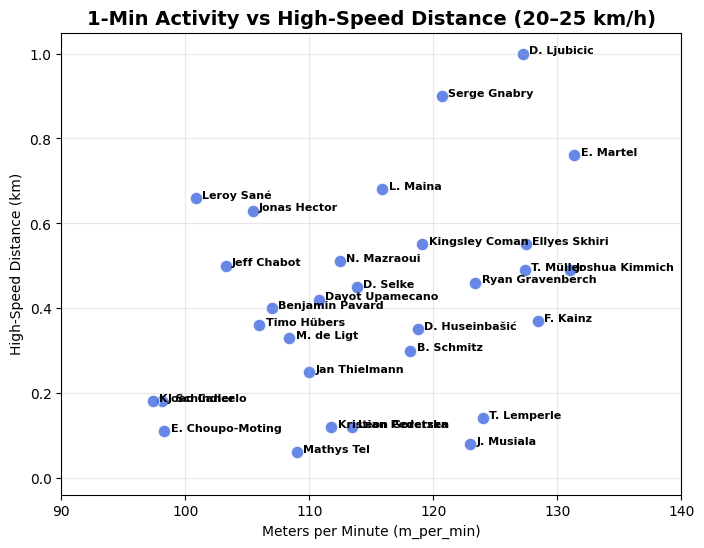

In [39]:
# 두 데이터 병합 (player 기준)
merged_stats = summary_df.merge(
	distances_by_speed.reset_index()[["player", '고속 질주 (20-25)']],
	on="player", how="left"
)
merged_stats.rename(columns={'고속 질주 (20-25)': '20-25'}, inplace=True)
# NaN → 0으로 채움
merged_stats.fillna(0, inplace=True)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
	data=merged_stats,
	x="m_per_min",
	y="20-25",
	s=80,
	color="royalblue",
	edgecolor="white",
	alpha=0.8
)
plt.title("1-Min Activity vs High-Speed Distance (20–25 km/h)", fontsize=14, weight='bold')
plt.xlim(90, 140)   # → x축 0~90까지로 확장 (필요 시 100, 120 등 조정 가능)

plt.xlabel("Meters per Minute (m_per_min)")
plt.ylabel("High-Speed Distance (km)")
plt.grid(alpha=0.3)

for _, row in merged_stats.iterrows():
	if row["m_per_min"] >= 90:  # 조건: 너무 작은 값은 제외
		plt.text(
			row["m_per_min"] + 0.5,   # x좌표 약간 오른쪽으로
			row["20-25"], 
			row["player"],
			fontsize=8,
			color="black",
			weight="bold"
		)

plt.show()


평균 위치 분석


In [40]:
def flip_coordinates(df: pd.DataFrame, field_length: float = 105, field_width: float = 68):
	# 전 후반 데이터의 좌표가 반전되어 있기 떄문에, 평균 위치를 구할때는 flip을 해줘야 함
	flipped_df = df.copy()
	second_half_mask = flipped_df["period_id"] == 2

	# 좌표 컬럼 탐색
	x_cols = [c for c in flipped_df.columns if c.endswith("_x")]
	y_cols = [c for c in flipped_df.columns if c.endswith("_y")]

	# X, Y 좌표 반전
	flipped_df.loc[second_half_mask, x_cols] = field_length - flipped_df.loc[second_half_mask, x_cols]
	flipped_df.loc[second_half_mask, y_cols] = field_width - flipped_df.loc[second_half_mask, y_cols]

	return flipped_df
dfl_traces_flipped = flip_coordinates(dfl_traces)


In [42]:
def plot_average_positions(pitch, tracking_df, player_dict):
	"""
	경기 전체에서 선수별 평균 위치를 계산하고 시각화하는 함수
	"""

	fig, ax = pitch.draw(figsize=(12, 8))

	team_color_map = {'H': 'blue', 'A': 'red'}
	team_name_map = {'H': 'Home', 'A': 'Away'}

	# 팀별 평균 위치 계산
	for team in ['H', 'A']:
		color = team_color_map[team]
		x_cols = [c for c in tracking_df.columns if c.startswith(team) and c.endswith('_x')]
		y_cols = [c for c in tracking_df.columns if c.startswith(team) and c.endswith('_y')]

		# 평균 좌표 계산
		avg_positions = []
		for x_col, y_col in zip(x_cols, y_cols):
			tracking_id = x_col[:-2]  # 예: H01_x → H01
			mean_x = tracking_df[x_col].mean(skipna=True)
			mean_y = tracking_df[y_col].mean(skipna=True)
			avg_positions.append((tracking_id, mean_x, mean_y))

		avg_df = pd.DataFrame(avg_positions, columns=['tracking_id', 'x', 'y'])

		# 시각화
		ax.scatter(avg_df['x'], avg_df['y'], s=500, color=color, alpha=0.6, edgecolors='white', label=team_name_map[team])

		# 선수 번호 + 이름 표시
		for _, row in avg_df.iterrows():
			num = ''.join(ch for ch in row['tracking_id'] if ch.isdigit())
			name = player_dict.get(row['tracking_id'], '')
			# ax.text(row['x'], row['y'] + 0.5, num, color='white', fontsize=8, fontweight='bold', ha='center')
			ax.text(row['x'], row['y'] - 0.5, name, color='white', fontsize=10, ha='center')

	ax.legend(
		loc='upper right',
		fontsize=10,
		facecolor='black',
		edgecolor='white',
		labelcolor='white',
		framealpha=0.6
	)
	plt.title("Average Player Positions", fontsize=16, weight='bold')
	plt.show()


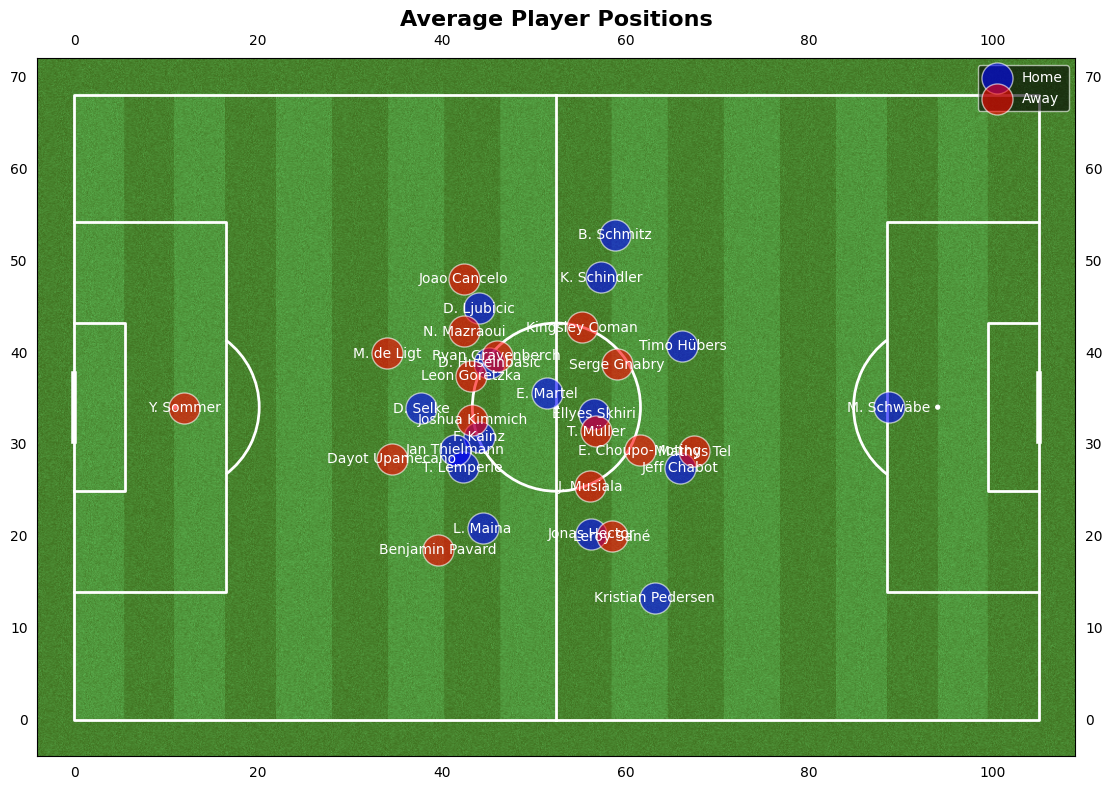

In [43]:
plot_average_positions(custom_pitch, dfl_traces_flipped, player_dict)


In [44]:

def plot_player_heatmap(pitch, tracking_df, tracking_id: str, player_name: str = None):
	"""
	특정 선수의 경기 중 위치 히트맵을 그리는 함수.

	"""
	# x, y 좌표 추출
	x = tracking_df[f'{tracking_id}_x']
	y = tracking_df[f'{tracking_id}_y']
	
	# NaN 제거
	valid = ~(x.isna() | y.isna())
	x = x[valid]
	y = y[valid]
	
	# 히트맵 계산 (피치 크기 105x68 기준)
	heatmap, xedges, yedges = np.histogram2d(
		y, x, bins=(34, 52), range=[[0, 68], [0, 105]] # bins로 grid 크기를 조절가능
	)

	# 피치 위에 히트맵 그리기
	fig, ax = pitch.draw()
	
	pos = ax.imshow(
		heatmap[::-1],
		extent=[0, 105, 0, 68],
		cmap='hot',           # 색상 스타일 ('hot', 'magma', 'viridis' 등 가능)
		alpha=0.8,
		vmin=0,
		vmax=np.percentile(heatmap, 99)  # 극단치 방지용
	)
	
	# 컬러바 + 제목
	cbar = plt.colorbar(pos, ax=ax, shrink=0.8)
	cbar.set_label('Position Density', fontsize=10)

	title_name = player_name if player_name else tracking_id
	plt.title(f"Position Heatmap — {title_name}", fontsize=14, weight='bold')
	plt.show()


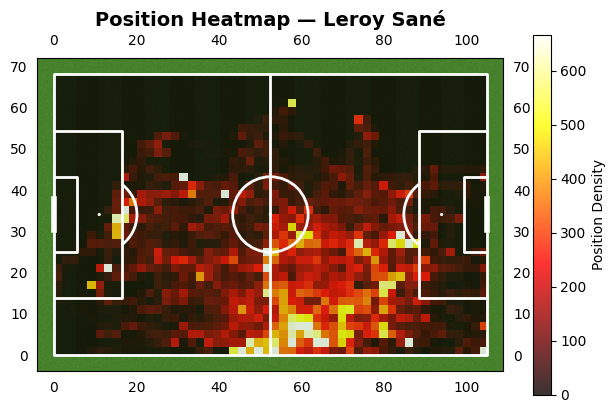

In [45]:
plot_player_heatmap(custom_pitch, dfl_traces_flipped, 'A10', player_dict['A10'])


## 보로노이 다이어그램

In [57]:
def demonstrate_voronoi_boundary_issue(vor, points):
    """
    계산된 Voronoi 다이어그램이 경기장 경계를 무시하고
    무한히 확장되는 문제를 시각적으로 보여줍니다.
    """
    # 1. 피치와 그림 객체 생성
    pitch = Pitch(pitch_color='grass', line_color='white')
    fig, ax = pitch.draw(figsize=(12, 8))

    # 2. Scipy의 내장 함수로 Voronoi 다이어그램 그리기
    # 이 함수는 무한 영역을 바깥으로 뻗어나가는 선으로 그려줍니다.
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange',
                    line_width=2, point_size=0) # 선수 점은 따로 그릴 것이므로 point_size=0

    # 3. 선수 위치 표시 (보로노이 선 위에)
    for i, row in points.iterrows():
        color = 'blue' if row.name.startswith('H') else 'red'
        ax.scatter(row.x, row.y, c=color, s=120, ec='black', zorder=3)
        ax.text(row.x, row.y, row.name[1:], color='white',
                fontsize=10, fontweight='bold', ha='center', va='center', zorder=4)

    # 4. (핵심) 축의 범위를 경기장보다 훨씬 넓게 설정하여 문제점을 드러냄
    ax.set_xlim(-30, 135)  # 경기장 X 범위: 0 ~ 105
    ax.set_ylim(-30, 98)   # 경기장 Y 범위: 0 ~ 68

    # 5. 제목으로 문제점 명시
    ax.set_title("The Problem: expanding infinitely", fontsize=16, pad=15)
    
    plt.show()



In [48]:
def calc_voronoi_from_frame(frame_data):
    """
    특정 프레임의 위치 데이터를 입력받아 Voronoi 다이어그램을 계산합니다.
    """
    # 유효한 선수 추출 (_x, _y 쌍이 모두 있는 경우)
    players = [
        c[:-2]
        for c in frame_data.dropna().keys()
        if c.endswith('_x') and f"{c[:-2]}_y" in frame_data
    ]

    # 선수별 좌표 컬럼 정의
    x_cols = [f"{p}_x" for p in players]
    y_cols = [f"{p}_y" for p in players]

    # 선수별 위치 데이터프레임 생성
    points = pd.DataFrame(index=players)
    points['x'] = frame_data[x_cols].astype(float).values
    points['y'] = frame_data[y_cols].astype(float).values

    # 경기장 내 좌표만 유지 (0 ≤ x ≤ 105, 0 ≤ y ≤ 68)
    points = points[
        (points['x'] >= 0) & (points['x'] <= 105) &
        (points['y'] >= 0) & (points['y'] <= 68)
    ]

    # Voronoi 다이어그램 계산
    vor = Voronoi(points[['x', 'y']].values)

    return points, vor


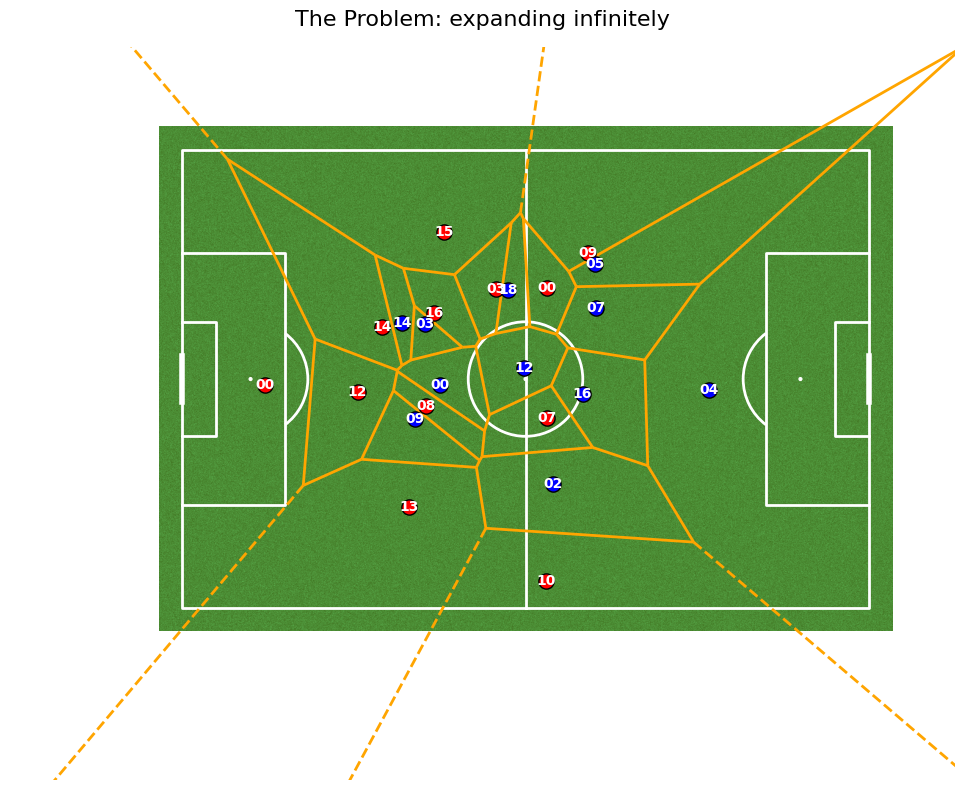

In [58]:
frame_to_analyze = 1000
points, vor = calc_voronoi_from_frame(dfl_traces.loc[frame_to_analyze])
demonstrate_voronoi_boundary_issue(vor, points)

In [59]:
def reflect_and_plot_voronoi(dfl_traces, frame_id, field_length=105, field_width=68):
    """
    특정 프레임의 선수 좌표를 이용해 Voronoi 대칭 확장을 적용하고 시각화합니다.
    """
    # 프레임 데이터 추출
    frame = dfl_traces.loc[frame_id]

    # 선수 좌표 추출
    player_cols_x = [c for c in frame.index if c.endswith('_x') and c.startswith(('H','A'))]
    player_cols_y = [c for c in frame.index if c.endswith('_y') and c.startswith(('H','A'))]

    points = pd.DataFrame({
        'tracking_id': [c[:-2] for c in player_cols_x],
        'x': [frame[c] for c in player_cols_x],
        'y': [frame[c] for c in player_cols_y],
    }).dropna()

    # 경기장 내부에 있는 선수만 남기기
    points = points[
        (points['x'] >= 0) & (points['x'] <= field_length) &
        (points['y'] >= 0) & (points['y'] <= field_width)
    ].reset_index(drop=True)

    # 대칭 이동된 점 확장
    # 원본, 좌반사, 우반사, 상반사, 하반사
    points_extended = np.hstack([
        np.vstack([points['x'], points['y']]),                             # 원본
        np.vstack([-points['x'], points['y']]),                            # 왼쪽 반사
        np.vstack([-points['x'] + field_length * 2, points['y']]),         # 오른쪽 반사
        np.vstack([points['x'], -points['y']]),                            # 위쪽 반사
        np.vstack([points['x'], -points['y'] + field_width * 2])           # 아래쪽 반사
    ]).T

    # Voronoi 계산
    vor = Voronoi(points_extended)

    # 시각화
    pitch = Pitch(pitch_color='grass', line_color='white')
    fig, ax = pitch.draw(figsize=(10, 7))

    n_players = len(points)
    n_home_players = len([tid for tid in points['tracking_id'] if tid.startswith('H')])

    # 대칭 이동된 포인트 표시
    for i in range(5):
        home_points = points_extended[n_players*i : n_players*i + n_home_players]
        away_points = points_extended[n_players*i + n_home_players : n_players*(i+1)]

        ax.scatter(*home_points.T, s=90, c='red', alpha=0.6, zorder=2)
        ax.scatter(*away_points.T, s=90, c='blue', alpha=0.6, zorder=2)

    ax.set_xlim(-110, field_length + 110)
    ax.set_ylim(-90, field_width + 90)
    ax.set_title(f"Frame {frame_id} — 대칭 이동된 선수 위치", fontsize=14, weight='bold', color='white')
    plt.show()

    return points, points_extended, vor


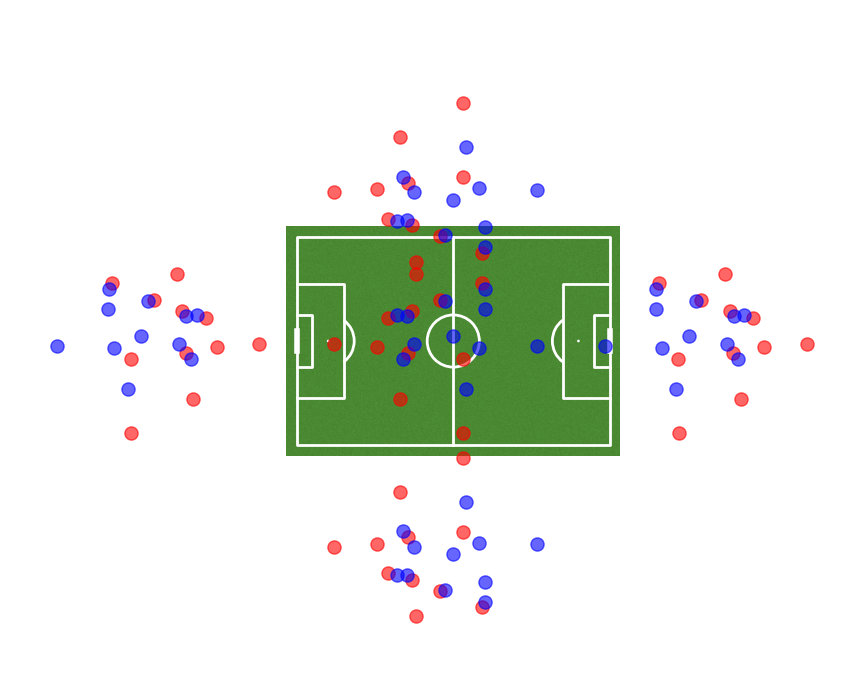

In [60]:
points, points_extended, vor = reflect_and_plot_voronoi(dfl_traces, frame_id=1000)

In [63]:
class SoccerVoronoi:
    """
    특정 프레임의 트래킹 데이터를 받아 보로노이 다이어그램을 계산하고,
    공간 점유율 분석 및 시각화를 제공하는 클래스.
    """
    def __init__(self, frame_data, field_length=105, field_width=68):
        """
        클래스 초기화 시 모든 계산을 수행합니다.

        Args:
            frame_data (pd.Series): 분석할 한 프레임의 wide-format 데이터.
            field_length (int): 경기장 가로 길이.
            field_width (int): 경기장 세로 길이.
        """
        self.pitch = Pitch(pitch_type='custom', pitch_color='grass', line_color='white', stripe=True, pitch_width=68, pitch_length=105, axis=True, label=True)
        self.frame_data = frame_data
        self.field_length = field_length
        self.field_width = field_width
        
        # 계산 결과를 저장할 속성들
        self.points = None
        self.vor = None
        self.clipped_polygons = {}

        # 초기화와 동시에 모든 계산 실행
        self._run_calculations()

    def _extract_points(self):
        """1. 프레임 데이터에서 선수 좌표를 추출하고 필터링합니다."""
        x_cols = [c for c in self.frame_data.index if c.endswith('_x') and c.startswith(('H','A'))]
        
        points_df = pd.DataFrame({
            'tracking_id': [c[:-2] for c in x_cols],
            'x': self.frame_data[x_cols].values,
            'y': self.frame_data[[c.replace('_x', '_y') for c in x_cols]].values,
        }).dropna()

        # 경기장 내부에 있는 선수만 사용
        self.points = points_df[
            (points_df['x'] >= 0) & (points_df['x'] <= self.field_length) &
            (points_df['y'] >= 0) & (points_df['y'] <= self.field_width)
        ].reset_index(drop=True)

    def _calculate_voronoi_with_reflection(self):
        """2. 경계 문제를 해결하기 위해 대칭 이동(mirroring) 후 보로노이를 계산합니다."""
        p = self.points
        l, w = self.field_length, self.field_width

        points_original = p[['x', 'y']].values
        points_top      = np.column_stack([p.x, w + (w - p.y)])
        points_left     = np.column_stack([-p.x, p.y])
        points_right    = np.column_stack([l + (l - p.x), p.y])
        points_bottom   = np.column_stack([p.x, -p.y])
        
        # 대각선 반사
        points_top_left      = np.column_stack([-p.x, w + (w - p.y)])
        points_top_right     = np.column_stack([l + (l - p.x), w + (w - p.y)])
        points_bottom_left   = np.column_stack([-p.x, -p.y])
        points_bottom_right  = np.column_stack([l + (l - p.x), -p.y])

        # 모양이 통일된 배열들을 vstack으로 안전하게 쌓습니다.
        points_extended = np.vstack([
            points_original,
            points_top, points_left, points_right, points_bottom,
            points_top_left, points_top_right, points_bottom_left, points_bottom_right
        ])
        
        self.vor = Voronoi(points_extended)
        
    def _clip_polygons_and_calculate_areas(self):
        """3. 계산된 보로노이 셀을 경기장 경계로 잘라내고 면적을 계산합니다."""
        pitch_boundary = box(0, 0, self.field_length, self.field_width)
        areas = []

        # 원본 선수들의 보로노이 셀에 대해서만 처리
        for i, region_idx in enumerate(self.vor.point_region[:len(self.points)]):
            region = self.vor.regions[region_idx]
            
            if -1 not in region and len(region) > 0:
                polygon = Polygon(self.vor.vertices[region])
                clipped_polygon = polygon.intersection(pitch_boundary)
                
                self.clipped_polygons[self.points.loc[i, 'tracking_id']] = clipped_polygon
                areas.append(clipped_polygon.area)
            else:
                # 열린 다각형이거나 유효하지 않은 경우
                self.clipped_polygons[self.points.loc[i, 'tracking_id']] = None
                areas.append(0)
        
        self.points['area'] = areas

    def _run_calculations(self):
        """모든 계산 단계를 순서대로 실행합니다."""
        self._extract_points()
        if self.points.empty:
            print("Warning: No valid player points found in the frame.")
            return
        self._calculate_voronoi_with_reflection()
        self._clip_polygons_and_calculate_areas()

    def plot_voronoi(self, ax=None):
        """계산된 보로노이 다이어그램을 시각화합니다."""
        if ax is None:
            fig, ax = self.pitch.draw(figsize=(12, 8))
        
        # 보로노이 셀 채우기
        for tracking_id, polygon in self.clipped_polygons.items():
            if polygon:
                color = "#5A91FF" if tracking_id.startswith('H') else "#E51818" 
                ax.fill(*polygon.exterior.xy, alpha=0.4, ec='white', fc=color, lw=2)

        # 선수 위치 및 번호 표시
        for i, row in self.points.iterrows():
            color = 'blue' if row.tracking_id.startswith('H') else 'red'
            ax.scatter(row.x, row.y, c=color, s=120, ec='black', zorder=3)
            ax.text(row.x, row.y, row.tracking_id[1:], color='white',
                    fontsize=10, fontweight='bold', ha='center', va='center', zorder=4)
        
        return ax

    def get_team_area_control(self):
        """팀별 공간 점유율을 계산하여 딕셔너리로 반환합니다."""
        home_area = self.points[self.points['tracking_id'].str.startswith('H')]['area'].sum()
        away_area = self.points[self.points['tracking_id'].str.startswith('A')]['area'].sum()
        total_area = home_area + away_area
        
        if total_area == 0:
            return {'Home': 0, 'Away': 0}
            
        return {
            'Home': home_area / total_area,
            'Away': away_area / total_area
        }

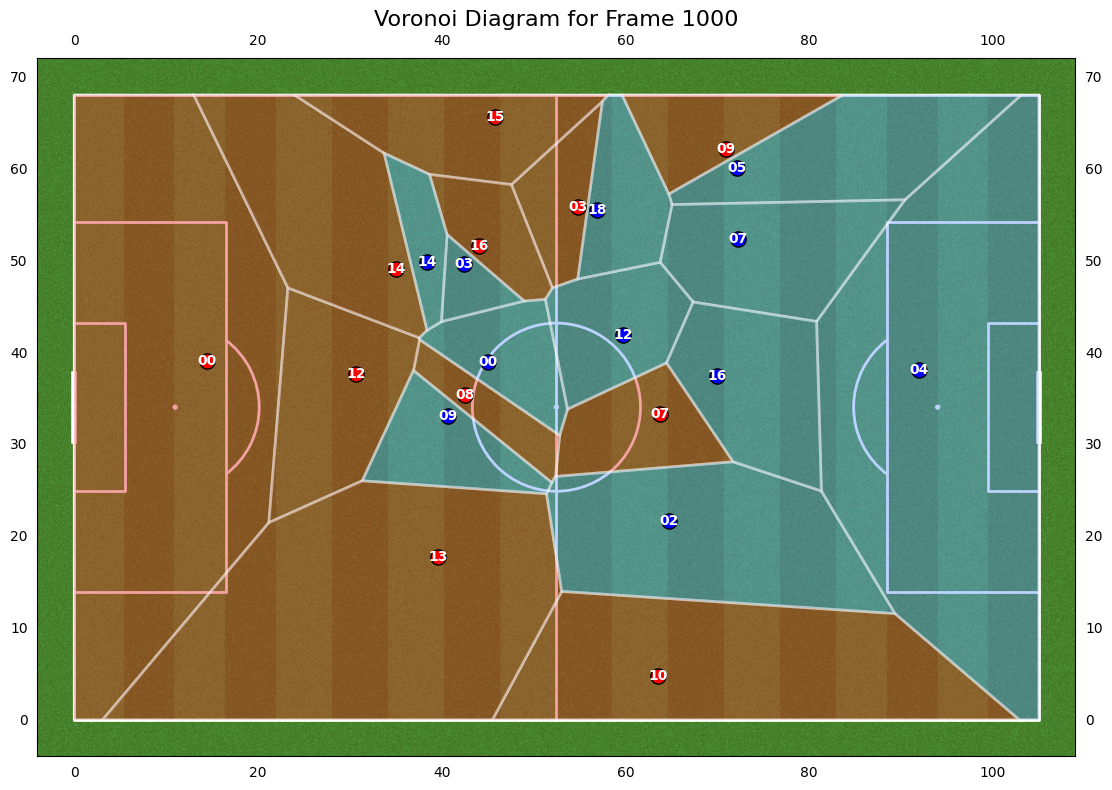

Frame 1000 공간 점유율:
 - Home: 42.6%
 - Away: 57.4%


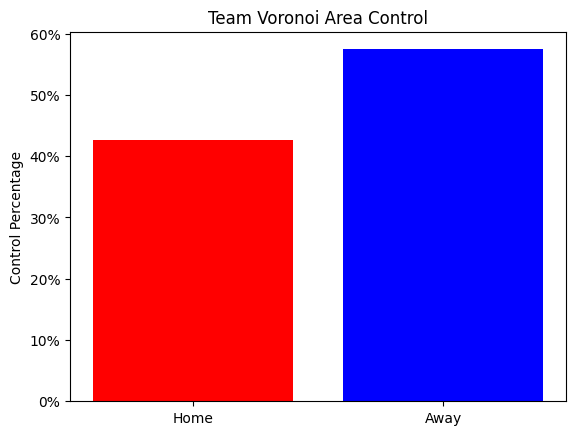

In [ ]:
frame_id_to_analyze = 1000
frame_data = dfl_traces.loc[frame_id_to_analyze]
voronoi_analyzer = SoccerVoronoi(frame_data)
ax = voronoi_analyzer.plot_voronoi()
ax.set_title(f"Voronoi Diagram for Frame {frame_id_to_analyze}", fontsize=16)
plt.show()

# --- 공간 점유율 분석 ---
team_control = voronoi_analyzer.get_team_area_control()
print(f"Frame {frame_id_to_analyze} 공간 점유율:")
print(f" - Home: {team_control['Home']:.1%}")
print(f" - Away: {team_control['Away']:.1%}")

# 막대그래프로 시각화
plt.bar(team_control.keys(), team_control.values(), color=['red', 'blue'])
plt.title("Team Voronoi Area Control")
plt.ylabel("Control Percentage")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.show()
#FYI Home team is Koln, and Away team is Bayern München

In [69]:
voronoi_analyzer.points.sort_values('area',ascending=False).head(10)

tracking_id      x      y         area
0          A00  14.44  38.98  1210.313535
14         H04   92.0  38.02  1156.875680
7          A13  39.64  17.73   921.122635
5          A10  63.61   4.78   592.660850
12         H02  64.73  21.64   457.945431
8          A14  35.02  49.02   363.380421
15         H05  72.14  60.07   270.157488
6          A12   30.7  37.66   259.602713
16         H07   72.3  52.32   248.154033
20         H16  69.95  37.39   239.451409

보로노이 애니메이션 제작

In [ ]:
def create_voronoi_animation(traces_df, pitch, start_frame, end_frame, filename="voronoi_animation.mp4"):
    """
    SoccerVoronoi 클래스를 사용하여 보로노이 다이어그램 애니메이션을 생성합니다.
    """
    # 1. 그림판(Figure)과 서브플롯(Axes) 설정
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1]) # 경기장과 막대그래프 비율 3:1
    ax_pitch = fig.add_subplot(gs[0])
    ax_bar = fig.add_subplot(gs[1])
    frames_to_render = range(start_frame, end_frame + 1)
    total_frames = len(frames_to_render)

    # 2. 매 프레임을 업데이트하는 함수
    def update(frame_index):
        # 이전 프레임의 그림 지우기
        ax_pitch.clear()
        ax_bar.clear()

        # 경기장 다시 그리기
        pitch.draw(ax=ax_pitch)
        
        # 현재 프레임 데이터로 SoccerVoronoi 객체 생성 및 계산
        frame_data = traces_df.loc[frame_index]
        voronoi_analyzer = SoccerVoronoi(frame_data)
        
        # 왼쪽: 보로노이 다이어그램 그리기
        voronoi_analyzer.plot_voronoi(ax=ax_pitch)
        ax_pitch.set_title(f"Voronoi Diagram - Frame {frame_index}", fontsize=14)

        # 오른쪽: 공간 점유율 막대그래프 그리기
        team_control = voronoi_analyzer.get_team_area_control()
        ax_bar.bar(team_control.keys(), team_control.values(), color=['red', 'blue'])
        ax_bar.set_title("Team Area Control")
        ax_bar.set_ylabel("Control Percentage")
        ax_bar.set_ylim(0, 1) # y축 범위를 0~1 (0%~100%)로 고정
        ax_bar.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

        # 진행 상황 출력
        current_frame_num = list(frames_to_render).index(frame_index) + 1
        print(f"Rendering frame: {current_frame_num}/{total_frames} (Index: {frame_index})", end="\r")

    # 3. FuncAnimation 객체 생성 및 비디오 저장
    ani = FuncAnimation(fig, update, frames=frames_to_render, interval=40)
    
    print(f"\nSaving animation to {filename}... (This might take a while)")
    ani.save(filename, writer='ffmpeg', fps=25)
    plt.close(fig)
    print("Animation saved successfully!")

# --- 함수 사용 예시 ---
# dfl_traces 데이터프레임이 있다고 가정합니다.
start = 1000
end = 1100 # 4초 분량 (100 프레임)의 짧은 클립 생성

create_voronoi_animation(
    traces_df=dfl_traces,
    pitch=custom_pitchpitch,
    start_frame=start,
    end_frame=end,
    filename="match_voronoi_clip.mp4"
)


Saving animation to match_voronoi_clip.mp4... (This might take a while)


Animation saved successfully!ex: 1100)


## Pitch Control

Pitch Control 계산 위해 형식 변경

In [ ]:
sys.path.append("/content/UOS-FootballDataAnalytics-Tutorial/week7/MyPlayerImputer")

from functions.data_prep import GamePreprocessor
from functions.pitch_control_prep import PitchControlCalculator
from functions.make_video import makeVideo

/home/EDA/MyPlayerImputer
/home/EDA/MyPlayerImputer


In [75]:
dfl_events = dfl_events.rename(columns={
    'gameclock': 'time_seconds',
    'pID': 'player_id',
    'position': 'position_name'
})

In [21]:
preprocessor = GamePreprocessor(dfl_traces, dfl_events, dfl_teams)
preprocessor.preprocess() 

pitch_calculator = PitchControlCalculator(
	merged_df=preprocessor.merged_df, 
	traces_df=preprocessor.traces_df,
	events_df=preprocessor.events_df, 
	team_sheets_lookup=preprocessor.team_sheets_lookup
)
real_melted_df = pitch_calculator.frame_flatten_df()

100%|██████████| 145967/145967 [00:11<00:00, 13087.94it/s]


In [81]:
print(list(preprocessor.merged_df.columns))

['Unnamed: 0_x', 'eID', 'time', 'tID', 'player_id', 'outcome', 'timestamp', 'minute', 'second', 'qualifier', 'period_id', 'team', 'match_id', 'start_x', 'start_y', 'player_code', 'attack_direction', 'Unnamed: 0_y', 'frame_id', 'ball_state', 'ball_owning_team_id', 'B00_x', 'B00_y', 'A00_speed', 'A00_vx', 'A00_vy', 'A00_x', 'A00_y', 'A01_speed', 'A01_vx', 'A01_vy', 'A01_x', 'A01_y', 'A02_speed', 'A02_vx', 'A02_vy', 'A02_x', 'A02_y', 'A03_speed', 'A03_vx', 'A03_vy', 'A03_x', 'A03_y', 'A04_speed', 'A04_vx', 'A04_vy', 'A04_x', 'A04_y', 'A05_speed', 'A05_vx', 'A05_vy', 'A05_x', 'A05_y', 'A06_speed', 'A06_vx', 'A06_vy', 'A06_x', 'A06_y', 'A07_speed', 'A07_vx', 'A07_vy', 'A07_x', 'A07_y', 'A08_speed', 'A08_vx', 'A08_vy', 'A08_x', 'A08_y', 'A09_speed', 'A09_vx', 'A09_vy', 'A09_x', 'A09_y', 'A10_speed', 'A10_vx', 'A10_vy', 'A10_x', 'A10_y', 'A11_speed', 'A11_vx', 'A11_vy', 'A11_x', 'A11_y', 'A12_speed', 'A12_vx', 'A12_vy', 'A12_x', 'A12_y', 'A13_speed', 'A13_vx', 'A13_vy', 'A13_x', 'A13_y', 'A14

In [82]:
preprocessor.merged_df[['period_id', 'time', 'team', 'start_x', 'start_y', 'eID', 'frame_id']].iloc[20:45,:]

period_id     time  team   start_x   start_y                  eID  \
20          1   65.264  Away  10.43800  30.93600            Play_Pass   
21          1   68.364  Away       NaN       NaN               Delete   
22          1   68.364  Away       NaN       NaN               Delete   
23          1   68.868  Away  17.60100  28.04800            Play_Pass   
24          1   71.653  Away  23.58600  19.98150            Play_Pass   
25          1   75.023  Away  40.65325   8.08050            Play_Pass   
26          1   76.496  Away  37.89000  18.19000            Play_Pass   
27          1   78.845  Away  30.24625  14.98875            Play_Pass   
28          1   80.159  Away  45.71225   0.57975            Play_Pass   
29          1   81.347  Away  45.59700   0.56675         TacklingGame   
30          1   83.800  Home  55.15000   1.06000      OtherBallAction   
31          1   84.142  Away  58.37100   0.60550         TacklingGame   
32          1   87.157  Away  32.93450   2.20475            Play_Pass   
33          1   92.063  Away  33.11975  30.74050            Play_Pass   
34          1   95.278  Home  46.48650  57.29100         BallClaiming   
35          1   95.279  Home  46.48325  57.29550            Play_Pass   
36          1   99.010  Home   7.30250  67.14750           Play_Cross   
37          1  102.336  Home  16.34200  41.50000  ShotAtGoal_ShotWide   
38          1  115.840  Away   3.72000  34.76000   GoalKick_Play_Pass   
39          1  117.535  Away   3.67375  50.33250            Play_Pass   
40          1  119.921  Away   3.20225  33.61700            Play_Pass   
41          1  120.587  Away       NaN       NaN               Delete   
42          1  120.587  Away       NaN       NaN               Delete   
43          1  122.604  Away  10.91500  14.31800            Play_Pass   
44          1  125.620  Away  27.93500   2.56000            Play_Pass   

    frame_id  
20     11631  
21     11709  
22     11709  
23     11721  
24     11791  
25     11875  
26     11912  
27     11971  
28     12003  
29     12033  
30     12095  
31     12103  
32     12178  
33     12301  
34     12381  
35     12381  
36     12475  
37     12558  
38     12896  
39     12938  
40     12998  
41     13014  
42     13014  
43     13065  
44     13140

1. 특정 장면 Pitch Control 계산

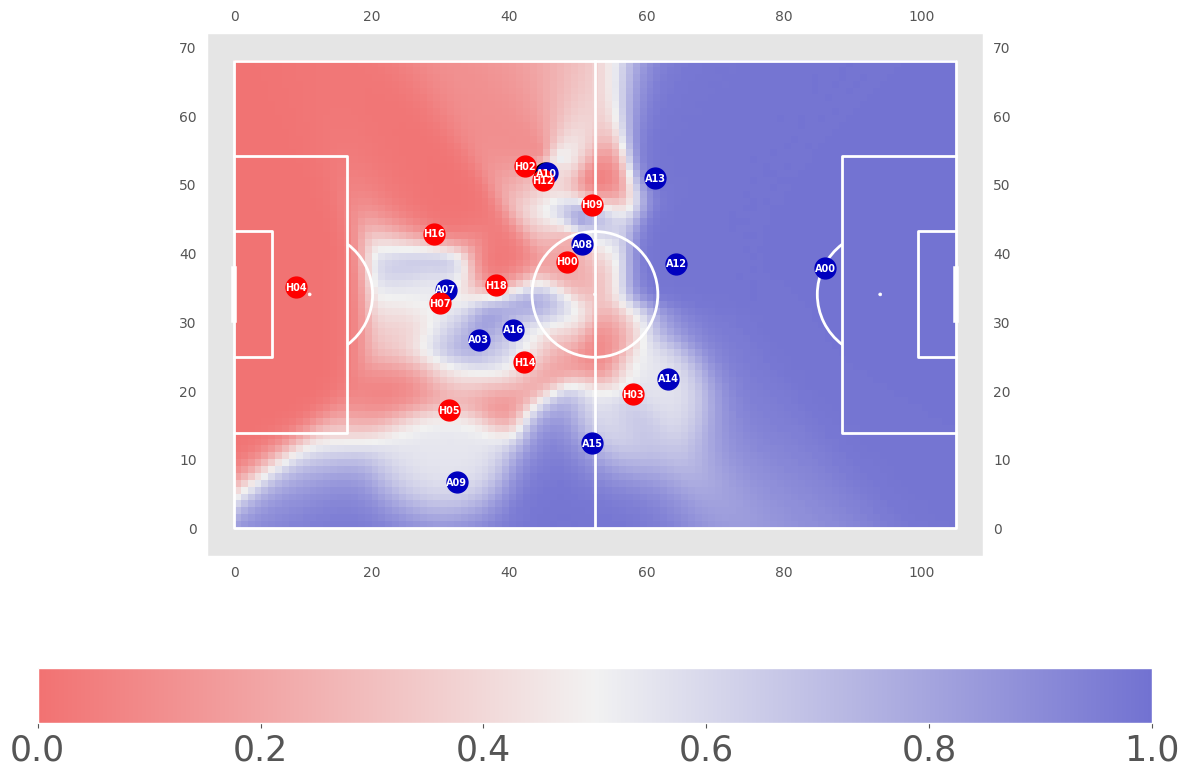

In [22]:
PPCFa, ax, frame_df = pitch_calculator.calculate_model_pitch_control(
	melted_df = real_melted_df,
	frame_id= 10720, #168790
)

In [ ]:
video_maker = makeVideo(pitch_calculator)
# start, end = counter_attack_sequences[3]
video_maker.makevideo(
	melted_df = real_melted_df,
	start_frame=10720,
	end_frame=10801,
	output_filename=f'pass_failed.mp4',
	attacking_only=True,
	attacking_penalty_area_only=False,   
	stride=1
)

NameError: name 'makeAnimation' is not defined